# Tutorial for mapping data with Tangram
by Tommaso Biancalani <biancalt@gene.com> and Ziqing Lu <luz21@gene.com>

- The notebook introduces to mapping single cell data on spatial data  using the Tangram method.
- The notebook uses data from mouse brain cortex (different than those adopted in the manuscript).

#### Last changelog
- June 13th - Tommaso Biancalani <biancalt@gene.com>

***
#### Installation

- Make sure `tangram-sc` is installed via `pip install tangram-sc`.
- Otherwise, edit and uncomment the line starting with `sys.path` specifying the Tangram folder.
- The Python environment needs to install the packages listed in `environment.yml`.

In [1]:
import os, sys #导入os和sys模块
import numpy as np #导入numpy模块
import pandas as pd #导入pandas模块
import matplotlib.pyplot as plt #导入matplotlib.pyplot模块
import seaborn as sns #导入seaborn模块
import scanpy as sc #导入scanpy模块
import torch #导入torch模块
sys.path.append('./')  # uncomment for local import #将当前目录添加到系统路径中
import tangram as tg #导入tangram模块

%load_ext autoreload #自动重新加载模块
%autoreload 2 
%matplotlib inline

tg.__version__ #查看tangram版本

'1.0.4'

***
#### Download the data
- If you have `wget` installed, you can run the following code to automatically download and unzip the data.

In [2]:
# Skip this cells if data are already downloaded
# !wget https://storage.googleapis.com/tommaso-brain-data/tangram_demo/mop_sn_tutorial.h5ad.gz -O data/mop_sn_tutorial.h5ad.gz
# !wget https://storage.googleapis.com/tommaso-brain-data/tangram_demo/slideseq_MOp_1217.h5ad.gz -O data/slideseq_MOp_1217.h5ad.gz
# !wget https://storage.googleapis.com/tommaso-brain-data/tangram_demo/MOp_markers.csv -O data/MOp_markers.csv
# !gunzip -f data/mop_sn_tutorial.h5ad.gz
# !gunzip -f data/slideseq_MOp_1217.h5ad.gz

- If you do not have `wget` installed, manually download data from the links below:
    - snRNA-seq datasets collected from adult mouse cortex:  [10Xv3 MOp](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/mop_sn_tutorial.h5ad.gz).
    - For spatial data, we will use one coronal slice of [Slide-seq2 data](
https://storage.googleapis.com/tommaso-brain-data/tangram_demo/slideseq_MOp_1217.h5ad.gz) (adult mouse brain; MOp area).
    - We will map them via a few hundred [marker genes](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/MOp_markers.csv), found in [literature](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1).
    - All datasets need to be unzipped: resulting `h5ad` and `csv` files should be placed in the `data` folder.

***
#### Load spatial data
- Spatial data need to be organized as a voxel-by-gene matrix. Here, Slide-seq data contains 9852 spatial voxels, in each of which there are 24518 genes measured.

In [4]:
path = os.path.join('./data', 'slideseq_MOp_1217.h5ad') # 空间数据路径
ad_sp = sc.read_h5ad(path) # 读取空间数据
ad_sp 

AnnData object with n_obs × n_vars = 9852 × 24518
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y'

In [6]:
ad_sp.obs # 空间数据的中每个voxel的信息 
# 包括nCount_RNA:每个voxel的RNA数量 nFeature_RNA:每个voxel的RNA特征数量
# nFeature_RNA:每个voxel的RNA特征数量?

,orig.ident,nCount_RNA,nFeature_RNA,x,y
ACCGGAACTTCTTC,0,14520.0,5453,3259.4,1233.7
GGGGGGGGGGGGGG,0,22554.0,8660,1662.6,2097.6
AAAGACCCAAAGGC,0,10774.0,4411,3050.3,1637.6
TCGGCGGTATCATT,0,10581.0,4033,1389.3,2045.8
TACGCCGGTACTGG,0,11075.0,4266,3022.8,1768.0
...,...,...,...,...,...
CAGTTGTGGAGCAG,0,10.0,10,1803.7,2009.3
ACTATGGTGTATCA,0,10.0,10,3538.7,1950.0
CACCCCCTAGAAAT,0,10.0,10,2004.3,2032.4
AAAGAATACGTACC,0,10.0,10,2161.3,2868.3


AnnData object with n_obs × n_vars = 9852 × 24518
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y'

- The voxel coordinates are saved in the fields `obs.x` and `obs.y` which we can use to visualize the spatial ROI. Each "dot" is the center of a 10um voxel.

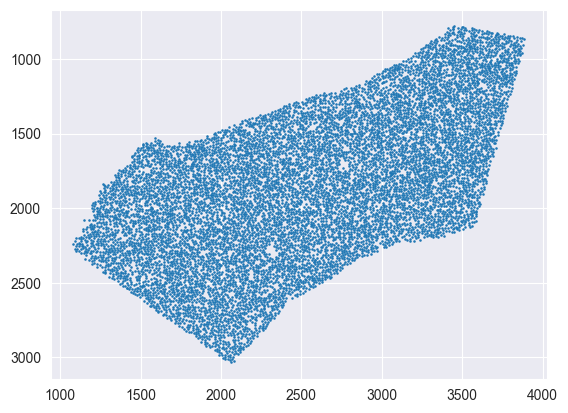

In [9]:
xs = ad_sp.obs.x.values # 每个voxel的x坐标 xs是一个一维向量
ys = ad_sp.obs.y.values # 每个voxel的y坐标 ys是一个一维向量
# plt.axis('off') # 关闭坐标轴
plt.scatter(xs, ys, s=.7) # 绘制散点图，s=.7表示散点的大小
plt.gca().invert_yaxis() # 反转y轴

***
#### Single cell data

- By single cell data, we generally mean either scRNAseq or snRNAseq.
- We start by mapping the MOp 10Xv3 dataset, which contains single nuclei collected from a posterior region of the primary motor cortex.
- They are approximately 26k profiled cells with 28k genes.

---
#### 单细胞数据
- 通常情况下，我们所指的单细胞数据要么是单细胞RNA测序（scRNAseq），要么是单细胞核RNA测序（snRNAseq）。
- 我们首先对包含来自初级运动皮层后部区域的单细胞核的MOp 10Xv3数据集进行了映射。
- 这个数据集包含大约26,000个已经被分析的细胞，拥有28,000个基因。
---

In [10]:
path = os.path.join('data','mop_sn_tutorial.h5ad') # 单细胞数据路径
ad_sc = sc.read_h5ad(path)  # 读取单细胞数据
ad_sc  

AnnData object with n_obs × n_vars = 26431 × 27742
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    layers: 'logcounts'

In [11]:
ad_sc.obs # 单细胞数据的每个细胞的信息

,QC,batch,class_color,class_id,class_label,cluster_color,cluster_labels,dataset,date,ident,individual,nCount_RNA,nFeature_RNA,nGene,nUMI,project,region,species,subclass_id,subclass_label
index,,,,,,,,,,,,,,,,,,,,
pBICCNsMMrMOpRPiM004d190318_CATTGCCGTGAGAGGG-4,PassQC,4,#00ADEE,2,Glutamatergic,#2EB934,L2/3 IT_3,2,190318_CATTGCCGTGAGAGGG,60,M004,15189.0,4816,3439,8522.0,BICCN,MOpRP,MM,7,L2/3 IT
pBICCNsMMrMOpRPiM004d190318_TCAAGTGAGCACACAG-4,PassQC,4,#00ADEE,2,Glutamatergic,#338C5E,L6 CT Cpa6,2,190318_TCAAGTGAGCACACAG,79,M004,11818.0,4031,5166,16883.0,BICCN,MOpRP,MM,13,L6 CT
pBICCNsMMrMOpRPiF008d190314_TTACGCCAGTCCCGAC-0,PassQC,0,#00ADEE,2,Glutamatergic,#69419D,L6b Col6a1,1,190314_TTACGCCAGTCCCGAC,84,F008,14412.0,4863,5042,19064.0,BICCN,MOpRP,MM,14,L6b
pBICCNsMMrMOpRPiF005d190318_CTGCAGGCAGGCTATT-1,PassQC,1,#808080,3,Non-Neuronal,#8D7C5D,Astro Aqp4_Slc7a10,1,190318_CTGCAGGCAGGCTATT,93,F005,4739.0,2384,4270,14240.0,BICCN,MOpRP,MM,16,Astro
pBICCNsMMrMOpRPiF006d190314_AATGCCACACTCTGCT-9,PassQC,9,#808080,3,Non-Neuronal,#8D7C5D,Astro Aqp4_Slc7a10,1,190314_AATGCCACACTCTGCT,93,F006,7462.0,3036,1556,2822.0,BICCN,MOpRP,MM,16,Astro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pBICCNsMMrMOpRPiF003d190318_TGTCAGATCGAGCCTG-11,PassQC,11,#00ADEE,2,Glutamatergic,#338C5E,L6 CT Cpa6,1,190318_TGTCAGATCGAGCCTG,79,F003,10983.0,3886,5410,21221.0,BICCN,MOpRP,MM,13,L6 CT
pBICCNsMMrMOpRPiF008d190314_TGTGCGGAGCAGTCTT-0,PassQC,0,#808080,3,Non-Neuronal,#8BA38D,PVM_1,1,190314_TGTGCGGAGCAGTCTT,114,F008,1711.0,1165,4481,11826.0,BICCN,MOpRP,MM,22,Micro-PVM
pBICCNsMMrMOpRPiF007d190314_TTTGATCAGCGAGGAG-3,PassQC,3,#00ADEE,2,Glutamatergic,#52B4B8,L5 IT Pld5_2,1,190314_TTTGATCAGCGAGGAG,66,F007,20215.0,5642,4892,14704.0,BICCN,MOpRP,MM,8,L5 IT


In [12]:
ad_sc.var # 单细胞数据的每个基因的信息

""
index
Xkr4
Gm1992
Gm37381
Rp1
Sox17
...
Ins1
AC133103.5
AC165294.2


- Usually, we work with data in raw count form, especially if the spatial data are in raw count form as well.
- If the data are in integer format, that probably means they are in raw count.
---
- 通常情况下，我们使用原始计数形式的数据，特别是如果空间数据也是原始计数形式的。
- 如果数据是整数格式，那可能意味着它们是原始计数。

In [15]:
np.unique(ad_sc.X.toarray()[0, :])  # 单细胞数据的第一个细胞的基因计数
#[0,:]选择了转换后的密集数组中的第一行（行索引为0），并选择了该行的所有列。
# 最后，np.unique() 是用于从数组中提取唯一值的NumPy函数。它将返回数组中不重复的值，并且这些值将按升序排列

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  33.,
        34.,  36.,  39.,  40.,  43.,  44.,  46.,  47.,  49.,  50.,  53.,
        56.,  57.,  58.,  62.,  68.,  69.,  73.,  77.,  80.,  85.,  86.,
        98., 104., 105., 118., 121., 126., 613.], dtype=float32)

- Here, we only do some light pre-processing as library size correction (in scanpy, via `sc.pp.normalize`) to normalize the number of count within each cell to a fixed number.
- Sometimes, we apply more sophisticated pre-processing methods, for example for batch correction, although mapping works great with raw data.
- Ideally, the single cell and spatial datasets, should exhibit signals as similar as possible and the pre-processing pipeline should be finalized to harmonize the signals.
---
- 在这里，我们只做了一些轻量级的预处理，如图书馆大小校正（在scanpy中，通过sc.pp.normalize）将每个细胞中的计数数量归一化为固定数量。
- 有时，我们会应用更复杂的预处理方法，例如批处理校正，尽管映射可以很好地处理原始数据。
- 理想情况下，单细胞和空间数据集应该尽可能地呈现相似的信号，并且预处理流程应该最终完成以协调信号。
---

In [16]:
sc.pp.normalize_total(ad_sc) # library size correction # 标准化

- It is a good idea to have annotations in the single cell data, as they will be projected on space after we map.
- In this case, cell types are annotated in the `subclass_label` field, for which we plot cell counts.
- Note that cell type proportion should be similar in the two datasets: for example, if `Meis` is a rare cell type in the snRNA-seq then it is expected to be a rare one even in the spatial data as well.

In [18]:
ad_sc.obs.subclass_label.value_counts() # cell type counts # 细胞类型计数

L5 IT        5623
Oligo        4330
L2/3 IT      3555
L6 CT        3118
Astro        2600
Micro-PVM    1121
Pvalb         972
L6 IT         919
L5 ET         903
L5/6 NP       649
Sst           627
Vip           435
L6b           361
Endo          357
Lamp5         332
VLMC          248
Peri          187
Sncg           94
Name: subclass_label, dtype: int64

***
#### Prepare to map
---
#### 准备映射

- Tangram learns a spatial alignment of the single cell data so that  _the gene expression of the aligned single cell data is as similar as possible to that of the spatial data_.
- In doing this, Tangram only looks at a subset genes, specified by the user, called the training genes.
- The choice of the training genes is a delicate step for mapping: they need to bear interesting signals and to be measured with high quality.
- Typically, a good start is to choose 100-1000 top marker genes, evenly stratified across cell types. Sometimes, we also use the entire transcriptome, or perform different mappings using different set of training genes to see how much the result change.
- For this case, we choose 253 marker genes of the MOp area which were curated [in a different study](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1).
---
- Tangram学习单细胞数据的空间对齐，以便 _对齐后的单细胞数据的基因表达与空间数据的基因表达尽可能相似_。
- 在这样做时，Tangram只查看用户指定的一组基因子集，称为训练基因。
- 训练基因的选择是映射的一个微妙的步骤：它们需要承载有趣的信号并且具有高质量的测量。
- 通常，一个好的开始是选择100-1000个顶级标记基因，均匀分层在细胞类型之间。有时，我们也使用整个转录组，或者使用不同的训练基因集执行不同的映射，以查看结果的变化程度。
- 对于这种情况，我们选择了MOp区域的253个标记基因，这些基因在[不同的研究中进行了筛选](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1)。
---


In [8]:
df_genes = pd.read_csv('data/MOp_markers.csv', index_col=0) # 读取基因列表
markers = np.reshape(df_genes.values, (-1, ))   # 将基因列表转换为一维数组
markers = list(markers)
len(markers)

253

- We now need to prepare the datasets for mapping by creating `training_genes` field in `uns` dictionary of the two AnnData structures. 
- This `training_genes` field contains genes subset on the list of training genes. This field will be used later inside the mapping function to create training datasets.
- Also, the gene order needs to be the same in the datasets. This is because Tangram maps using only gene expression, so the $j$-th column in each matrix must correspond to the same gene.
- And if data entries of a gene are all zero, this gene will be removed
- This task is performed by the helper `pp_adatas`.
- In the pp_adatas function, the gene names are converted to lower case to get rid of the inconsistent capitalization. If this is not wanted, you can set the parameter gene_to_lowercase = False 

In [10]:
tg.pp_adatas(ad_sc, ad_sp, genes=markers)

INFO:root:249 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:18000 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


- You'll now notice that the two datasets now contain 249 genes, but 253 markers were provided.
- This is because the marker genes need to be shared by both dataset. If a gene is missing, `pp_adatas` will just take it out.
- Finally, the `assert` line below is a good way to ensure that the genes in the `training_genes` field in `uns` are actually ordered in both `AnnData`s.

In [11]:
ad_sc

AnnData object with n_obs × n_vars = 26431 × 26496
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    var: 'n_cells'
    uns: 'training_genes', 'overlap_genes'
    layers: 'logcounts'

In [12]:
ad_sp

AnnData object with n_obs × n_vars = 9852 × 20864
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y', 'uniform_density', 'rna_count_based_density'
    var: 'n_cells'
    uns: 'training_genes', 'overlap_genes'

In [13]:
assert ad_sc.uns['training_genes'] == ad_sp.uns['training_genes']

***
#### Map

- We can now train the model (_ie_ map the single cell data onto space).
- Mapping should be interrupted after the score plateaus,which can be controlled by passing the `num_epochs` parameter. 
- The score measures the similarity between the gene expression of the mapped cells vs spatial data: higher score means better mapping.
- Note that we obtained excellent mapping even if Tangram converges to a low scores (the typical case is when the spatial data are very sparse): we use the score merely to assess convergence.
- If you are running Tangram with a GPU, uncomment `device=cuda:0` and comment the line `device=cpu`. On a MacBook Pro 2018, it takes ~1h to run. On a P100 GPU it should be done in a few minutes.
- For this basic mapping, we do not use regularizers. More sophisticated loss functions can be used using the Tangram library (refer to manuscript or dive into the code). For example, you can pass your `density_prior` with the hyperparameter `lambda_d` to regularize the spatial density of cells. Currently `uniform`, `rna_count_based` and customized input array are supported for `density_prior` argument.
- Instead of mapping single cells, we can "average" the cells within a cluster and map the averaged cells instead, which drammatically improves performances. This suggestion was proposed by Sten Linnarsson. To activate this mode, select `mode='clusters'` and pass the annotation field to `cluster_label`.

In [14]:
ad_map = tg.map_cells_to_space(
    adata_sc=ad_sc,
    adata_sp=ad_sp,
    # device='cpu',
    device='cuda:0',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 249 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.103, KL reg: 0.558


OutOfMemoryError: CUDA out of memory. Tried to allocate 994.00 MiB (GPU 0; 6.00 GiB total capacity; 4.89 GiB already allocated; 0 bytes free; 4.90 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

- The mapping results are stored in the returned `AnnData` structure, saved as `ad_map`, structured as following:
    - The cell-by-spot matrix `X` contains the probability of cell $i$ to be in spot $j$.
    - The `obs` dataframe contains the metadata of the single cells.
    - The `var` dataframe contains the metadata of the spatial data.
    - The `uns` dictionary contains a dataframe with various information about the training genes (saved ad `train_genes_df`).
- We can now save the mapping results for post-analysis.

***
#### Analysis

- The most common application for mapping single cell data onto space is to transfer the cell type annotations onto space.
- This is dona via `plot_cell_annotation`, which visualizes spatial probability maps of the `annotation` in the `obs` dataframe (here, the `subclass_label` field). You can set `robust` argument to `True` and at the same time set the `perc` argument to set the range to the colormap, which would help remove outliers.
- The following plots recover cortical layers of excitatory neurons and sparse patterns of glia cells. The boundaries of the cortex are defined by layer 6b (cell type _L6b_) and oligodendrocytes are found concentrated into sub-cortical region, as expected.
- Yet, the _VLMC_ cell type patterns does not seem correct: _VLMC_ cells are clustered in the first cortical layer, whereas here are sparse in the ROI. This usually means that either (1) we have not used good marker genes for _VLMC_ cells in our training genes (2) the present marker genes are very sparse in the spatial data, therefore they don't contain good mapping signal.

In [15]:
import tangram as tg

tg.project_cell_annotations(ad_map, ad_sp, annotation='subclass_label')
annotation_list = list(pd.unique(ad_sc.obs['subclass_label']))
tg.plot_cell_annotation_sc(ad_sp, annotation_list,x='x', y='y',spot_size= 60, scale_factor=0.1, perc=0.001)

NameError: name 'ad_map' is not defined

- Let's try to get a deeper sense of how good this mapping is. A good helper is `plot_training_scores` which gives us four panels:
    - The first panels is a histogram of the simlarity score for each training gene. Most genes are mapped with very high similarity (> .9) although few of them have score ~.5. We would like to understand why for these genes the score is lower.
    - The second panel shows that there is a neat correlation between the training score of a gene (y-axis) and the sparsity of that gene in the snRNA-seq data (x-axis). Each dot is a training gene. The trend is that the sparser the gene the higher the score: this usually happens because very sparse gene are easier to map, as their pattern is matched by placing a few "jackpot cells" in the right spots.
    - The third panel is similar to the second one, but contains the gene sparsity of the spatial data. Spatial data are usually more sparse than single cell data, a discrepancy which is often responsible for low quality mapping.
    - In the last panel, we show the training scores as a function of the difference in sparsity between the dataset. For genes with comparable sparsity, the mapped gene expression is very similar to that in the spatial data. However, if a gene is quite sparse in one dataset (typically, the spatial data) but not in other, the mapping score is lower. This occurs as Tangram cannot properly matched the gene pattern because of inconsistent amount of dropouts between the datasets.

In [ ]:
tg.plot_training_scores(ad_map, bins=10, alpha=.5)

- Although the above plots give us a summary of scores at single-gene level, we would need to know _which_ are the genes are mapped with low scores.
- These information can be access from the dataframe `.uns['train_genes_df']` from the mapping results; this is the dataframe used to build the four plots above.

- We want to inspect gene expression of training genes mapped with low scores, to understand the quality of mapping. 
- First, we need to generate "new spatial data" using the mapped single cell: this is done via `project_genes`.
- The function accepts as input a mapping (`adata_map`) and corresponding single cell data (`adata_sc`).
- The result is a voxel-by-gene `AnnData`, formally similar to `ad_sp`, but containing gene expression from the mapped single cell data rather than Slide-seq.

In [ ]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=ad_sc)
ad_ge

- We now choose a few training genes mapped with low score.

In [ ]:
genes = ['rgs6', 'satb2',  'cdh12']
ad_map.uns['train_genes_df'].loc[genes]

- To visualize gene patterns, we use the helper `plot_genes`. This function accepts two voxel-by-gene `AnnData`: the actual spatial data  (`adata_measured`), and a Tangram spatial prediction (`adata_predicted`). The function returns gene expression maps from the two spatial `AnnData` on the genes `genes`.
- As expected, the predited gene expression is less sparse albeit the main patterns are captured. For these genes, we trust more the mapped gene patterns, as Tangram "corrects" gene expression by aligning in space less sparse data.

In [ ]:
tg.plot_genes_sc(genes, adata_measured=ad_sp, adata_predicted=ad_ge, spot_size=50, scale_factor=0.1, perc = 0.001, return_figure=False)

- An even stronger example is found in genes that are not detected in the spatial data, but are detected in the single cell data. They are removed before training with `pp_adatas` function. But tangram could still generate insight on how the spatial patterns look like.

In [ ]:
genes=['mrgprx2', 'muc20', 'chrna2']
tg.plot_genes_sc(genes, adata_measured=ad_sp, adata_predicted=ad_ge, spot_size=50, scale_factor=0.1, perc=0.001, return_figure=False)

- So far, we only inspected genes used to align the data (training genes), but the mapped single cell data, `ad_ge` contains the whole transcriptome. That includes more than 26k test genes.

In [ ]:
(ad_ge.var.is_training == False).sum()

- We can use `plot_genes` to inspect gene expression of non training genes. This is an essential step as prediction of gene expression is the how we validate mapping.
- Before doing that, it is convenient to compute the similarity scores of all genes, which can be done by `compare_spatial_geneexp`. This function accepts two spatial `AnnData`s (_ie_ voxel-by-gene), and returns a dataframe with simlarity scores for all genes. Training genes are flagged by the Boolean field `is_training`.
- If we also pass single cell `AnnData` to `compare_spatial_geneexp` function like below, a dataframe with additional sparsity columns - sparsity_sc (single cell data sparsity) and sparsity_diff (spatial data sparsity - single cell data sparsity) will return. This is required if we want to call `plot_test_scores` function later with the returned datafrme from `compare_spatial_geneexp` function.

In [ ]:
df_all_genes = tg.compare_spatial_geneexp(ad_ge, ad_sp, ad_sc)
df_all_genes

- The plot below give us a summary of scores at single-gene level for test genes

In [ ]:
tg.plot_auc(df_all_genes)

- Let's plot the scores of the test genes and see how they compare to the training genes. Following the strategy in the previous plots, we visualize the scores as a function of the sparsity of the spatial data.
- (We have not wrapped this call into a function yet).

- Again, sparser genes in the spatial data are predicted with low scores, which is due to the presence of dropouts in the spatial data.
- Let's choose a few test genes with varied scores and compared predictions vs measured gene expression.

In [ ]:
genes = ['snap25', 'atp1b1', 'atp1a3', 'ctgf', 'nefh', 'aak1', 'fa2h', ]
df_all_genes.loc[genes]

- We can use again `plot_genes` to visualize gene patterns.
- Interestingly, the agreement for genes `Atp1b1` or `Apt1a3`, seems less good than that for `Ctgf` and `Nefh`, despite the scores are higher for the former genes. This is because even though the latter gene patterns are localized correctly, their expression values are not so well correlated (for instance, in `Ctgf` the "bright yellow spot" is in different part of layer 6b). In contrast, for `Atpb1` the gene expression pattern is largely recover, even though the overall gene expression in the spatial data is more dim.

In [ ]:
tg.plot_genes_sc(genes, adata_measured=ad_sp, adata_predicted=ad_ge, spot_size=50, scale_factor=0.1, perc=0.001, return_figure=False)

***
#### Leave-One-Out Cross Validation (LOOCV)

- If number of genes is small, Leave-One-Out cross validation (LOOCV) is supported in Tangram to evaluate mapping performance. 
- LOOCV supported by Tangram:
    - Assume the number of genes we have in the dataset is N. 
    - LOOCV would iterate over and map on the genes dataset N times.
    - Each time it hold out one gene as test gene (1 test gene) and trains on the rest of all genes (N-1 training genes).
    - After all trainings are done, average test/train score will be computed to evaluate the mapping performance.
- Assume all genes we have is the training genes in the example above. Here we demo the LOOCV mapping at cluster level. 
- Restart the kernel and load single cell, spatial and gene markers data
- Run `pp_adatas` to prepare data for mapping

In [ ]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import tangram as tg

In [ ]:
path = os.path.join('data', 'slideseq_MOp_1217.h5ad')
ad_sp = sc.read_h5ad(path)

path = os.path.join('data','mop_sn_tutorial.h5ad')
ad_sc = sc.read_h5ad(path)
sc.pp.normalize_total(ad_sc)

df_genes = pd.read_csv('data/MOp_markers.csv', index_col=0)
markers = np.reshape(df_genes.values, (-1, ))
markers = list(markers)

tg.pp_adatas(ad_sc, ad_sp, genes=markers)

In [ ]:
cv_dict, ad_ge_cv, df = tg.cross_val(ad_sc, 
                                     ad_sp, 
                                     device='cuda:0', 
                                     mode='clusters',
                                     cv_mode='loo',
                                     num_epochs=1000,
                                     cluster_label='subclass_label',
                                     return_gene_pred=True,
                                     verbose=False,
                                     )

* `cross_val` function will return `cv_dict` and `ad_ge_cv` and `df_test_genes` in `LOOCV` mode. `cv_dict` contains the average score for cross validation, `ad_ge_cv` stores the predicted expression value for each gene, and `df_test_genes` contains scores and sparsity for each test genes.


In [ ]:
cv_dict

* We can use `plot_test_scores` to display an overview of the cross validation test scores of each gene vs. sparsity. 

In [ ]:
tg.plot_test_scores(df, bins=10, alpha=.7)

- Now, let's compare a few genes between their ground truth and cross-validation predicted spatial pattern by calling the function `plot_genes`

In [ ]:
ad_ge_cv.var.sort_values(by='test_score', ascending=False)

In [ ]:
ranked_genes = list(ad_ge_cv.var.sort_values(by='test_score', ascending=False).index.values)
top_genes = ranked_genes[:3]
bottom_genes = ranked_genes[-3:]

In [ ]:
tg.plot_genes_sc(genes=top_genes, adata_measured=ad_sp, adata_predicted=ad_ge_cv, x = 'x', y='y',spot_size=50, scale_factor=0.1, perc=0.001, return_figure=False)

In [ ]:
tg.plot_genes_sc(genes=bottom_genes, adata_measured=ad_sp, adata_predicted=ad_ge_cv,x='x', y='y', spot_size=50, scale_factor=0.1, perc=0.001, return_figure=False)